<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

activations_array = np.load("/content/drive/MyDrive/SAE_project/last_hidden_activations.npy")
print(activations_array.shape)

# Min-Max normalization
min_vals = activations_array.min(axis=0)
max_vals = activations_array.max(axis=0)

activations_normalized = (activations_array - min_vals) / (max_vals - min_vals)

print("Normalized range:", activations_normalized.min(), activations_normalized.max())

(3475, 25)
Normalized range: 0.0 1.0


 We are loading the data from a trained PINNs model with 2 hidden layers having 25 neurosn each(architecture [3, 25, 25, 3]), solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 25 neurons
 These activations are collected for all training points(N=3475).

So our complete data looks like:  

$$A = \begin{bmatrix} a_1 \\ a_2\\ \vdots \\ a_{N} \end{bmatrix} $$


where $a_k \in \mathbb{R}^{25} $ represents the activation values corresponding to the $k^{th}$ training point of the PDE domain,  


In other words, the SAE takes these activations as input and learns a latent representation of them through its encoder, while the decoder attempts to reconstruct the original activations as

$$\vec{y} = {\rm AE}(\vec{x})= \sigma_2(W_2 E(\vec{x}) + \vec{b}_2), E(\vec{x}) = \sigma_1(W_1 \vec{x} + \vec{b}_1) $$

$$\hat{a}_k = {\rm AE}(\vec{a}_k) $$


where $\hat{I}_k$ is the reconstructed activation vector.


The loss in the sparse autoencoder consists of two parts: **reconstruction loss** and **sparsity penalty**.

1. **Reconstruction loss**:
$$
L_{rec} = \frac{1}{m} \sum_{k=1}^{m} (a_k - \hat{a}_k)^2
$$

2. **Sparsity penalty**:

For each hidden neuron, the average activation across a mini-batch of size m is
$$
\hat{\rho_j} = \frac{1}{m} \sum_{i=1}^{m} h_j^i
$$
 where $h_j^i$ is activation of jth neuron for $i^{th}$ sample

The KL divergence between the target sparsity $\rho$ and the actual average activation $\hat{\rho_j}$ is
$$
\text{div}_j = \rho \log \frac{\rho}{\hat{\rho_j}} + (1-\rho) \log \frac{1-\rho}{1-\hat{\rho_j}}
$$
The total loss used for training the SAE is
$$
\text{Loss} = L_{rec} + \lambda \sum_{j=1}^{h_{dim}} \text{div}_j
$$
Here, $\lambda$ is a weighting factor(`sparsity_lamda`) that controls how strongly the sparsity constraint influences the total loss
This ensures the model reconstructs inputs accurately while maintaining sparsity in the hidden layer.



Normalization rescales neuron activations to a common range, making them easier to visualize, compare, and analyze.

| Theoretical Symbol | Code Variable |
|--------------------|---------------|
| $N$ | `number of training points` |
| $d_{in}$ | `in_dim` |
| $h_{dim}$ | `h_dim` |
| $\sigma_1$ | `nn.Sigmoid()` |
| $\sigma_2$ | `nn.Tanh()` |
| $\rho$ | `sparsity_target` |
| $\lambda$ | `sparsity_lambda` |
| $\hat{\rho}_j$ | `average activation` |
| $L_{rec}$ | `mse_loss` |
| $L$ | `loss` |
| $\eta$ | `lr` |
| — | `optimizer (Adam)` |
| m | `batch_size` |
| — | `n_epochs` |

In [ ]:
hidden_tensor = torch.tensor(activations_normalized, dtype=torch.float32)

print(hidden_tensor.shape)

torch.Size([3475, 25])


To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch with shuffuling

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [ ]:

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=139, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):
        super().__init__()

        # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
        # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.

        self.xavier_norm_init = xavier_norm_init
       # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        # The decoder reconstructs the original input from the compressed hidden representation.
        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)



During training, the full dataset of neuron activations is divided into **mini-batches**. Each mini-batch contains a subset of the total samples (e.g., 139 samples per batch in our case), which is fed into the sparse autoencoder at a time. This approach allows the model to **update its weights iteratively** after processing each batch rather than waiting to process the entire dataset.

Using mini-batches improves **training efficiency**, reduces memory usage, and can help the model converge faster. In the code, the `DataLoader` automatically selects these mini-batches in a **random order for each epoch** if `shuffle=True`, ensuring that the model sees different combinations of samples over training epochs.



>>> Training SAE | h_dim=60, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.421784203
Epoch 500/3000 - Loss: 0.000273172
Epoch 1000/3000 - Loss: 0.000031056
Epoch 1500/3000 - Loss: 0.000013223
Epoch 2000/3000 - Loss: 0.000009001
Epoch 2500/3000 - Loss: 0.000006977
 Done: h_dim=60, sparsity_target=0.01, Final Loss=0.000006150



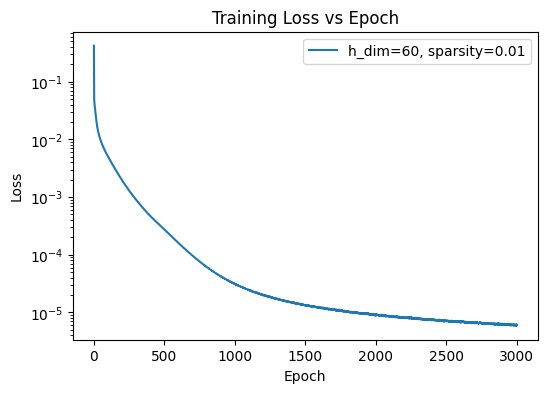

 Done: h_dim=60, sparsity_target=0.01, Final Loss=0.000006150


>>> Training SAE | h_dim=60, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.291572595
Epoch 500/3000 - Loss: 0.000087245
Epoch 1000/3000 - Loss: 0.000016464
Epoch 1500/3000 - Loss: 0.000010920
Epoch 2000/3000 - Loss: 0.000008805
Epoch 2500/3000 - Loss: 0.000007383
 Done: h_dim=60, sparsity_target=0.04, Final Loss=0.000006460



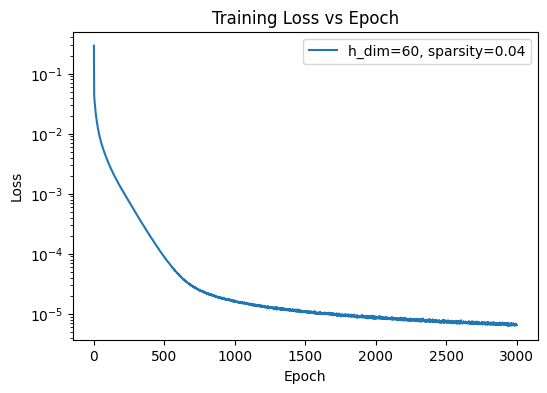

 Done: h_dim=60, sparsity_target=0.04, Final Loss=0.000006460


>>> Training SAE | h_dim=60, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.304055624
Epoch 500/3000 - Loss: 0.000050261
Epoch 1000/3000 - Loss: 0.000017491
Epoch 1500/3000 - Loss: 0.000012999
Epoch 2000/3000 - Loss: 0.000010811
Epoch 2500/3000 - Loss: 0.000009489
 Done: h_dim=60, sparsity_target=0.08, Final Loss=0.000008349



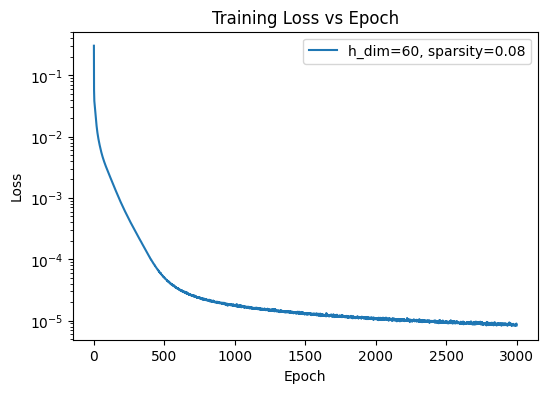

 Done: h_dim=60, sparsity_target=0.08, Final Loss=0.000008349


>>> Training SAE | h_dim=60, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.214843667
Epoch 500/3000 - Loss: 0.000042869
Epoch 1000/3000 - Loss: 0.000020823
Epoch 1500/3000 - Loss: 0.000016255
Epoch 2000/3000 - Loss: 0.000013827
Epoch 2500/3000 - Loss: 0.000012206
 Done: h_dim=60, sparsity_target=0.12, Final Loss=0.000010595



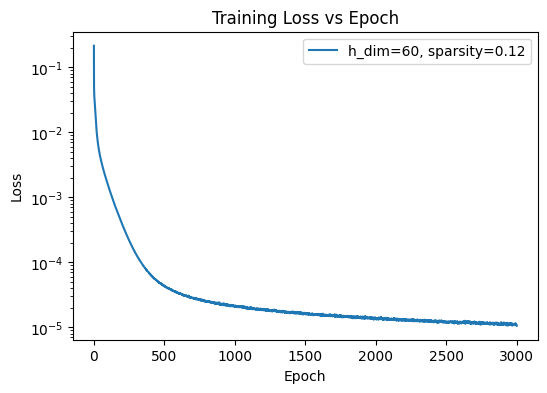

 Done: h_dim=60, sparsity_target=0.12, Final Loss=0.000010595


>>> Training SAE | h_dim=80, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.222474332
Epoch 500/3000 - Loss: 0.000165874
Epoch 1000/3000 - Loss: 0.000016653
Epoch 1500/3000 - Loss: 0.000007816
Epoch 2000/3000 - Loss: 0.000005709
Epoch 2500/3000 - Loss: 0.000004878
 Done: h_dim=80, sparsity_target=0.01, Final Loss=0.000004008



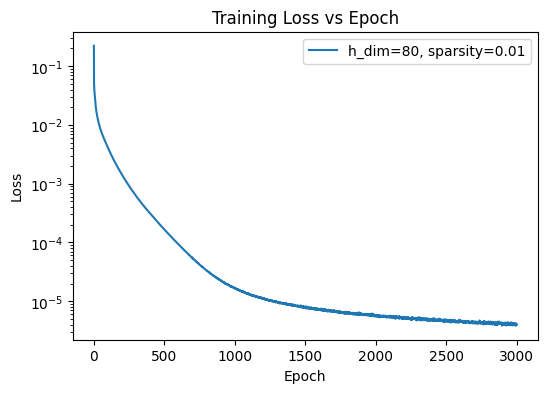

 Done: h_dim=80, sparsity_target=0.01, Final Loss=0.000004008


>>> Training SAE | h_dim=80, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.122843555
Epoch 500/3000 - Loss: 0.000037148
Epoch 1000/3000 - Loss: 0.000011823
Epoch 1500/3000 - Loss: 0.000008643
Epoch 2000/3000 - Loss: 0.000006856
Epoch 2500/3000 - Loss: 0.000005866
 Done: h_dim=80, sparsity_target=0.04, Final Loss=0.000005424



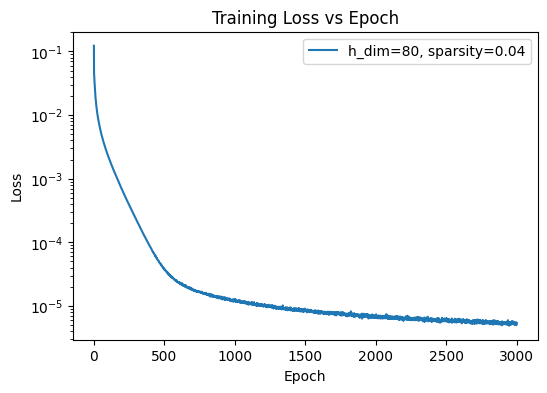

 Done: h_dim=80, sparsity_target=0.04, Final Loss=0.000005424


>>> Training SAE | h_dim=80, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.103602394
Epoch 500/3000 - Loss: 0.000030821
Epoch 1000/3000 - Loss: 0.000015107
Epoch 1500/3000 - Loss: 0.000011612
Epoch 2000/3000 - Loss: 0.000009498
Epoch 2500/3000 - Loss: 0.000009065
 Done: h_dim=80, sparsity_target=0.08, Final Loss=0.000007996



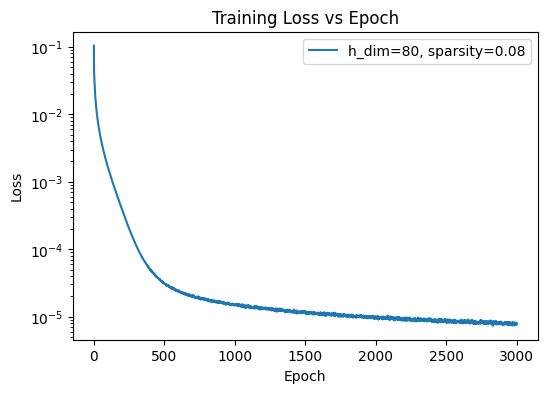

 Done: h_dim=80, sparsity_target=0.08, Final Loss=0.000007996


>>> Training SAE | h_dim=80, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.210186912
Epoch 500/3000 - Loss: 0.000042228
Epoch 1000/3000 - Loss: 0.000020287
Epoch 1500/3000 - Loss: 0.000015002
Epoch 2000/3000 - Loss: 0.000013077
Epoch 2500/3000 - Loss: 0.000012211
 Done: h_dim=80, sparsity_target=0.12, Final Loss=0.000010795



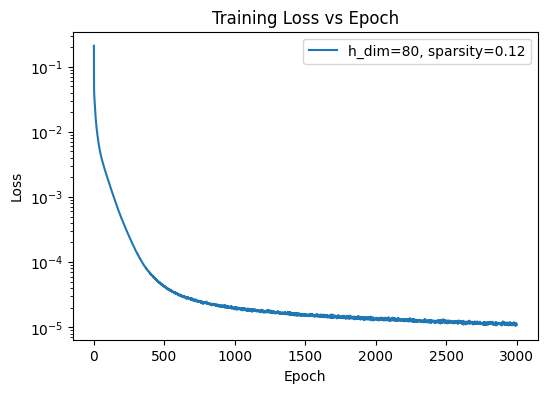

 Done: h_dim=80, sparsity_target=0.12, Final Loss=0.000010795


>>> Training SAE | h_dim=100, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.380518614
Epoch 500/3000 - Loss: 0.000198899
Epoch 1000/3000 - Loss: 0.000015571
Epoch 1500/3000 - Loss: 0.000006861
Epoch 2000/3000 - Loss: 0.000005127
Epoch 2500/3000 - Loss: 0.000003947
 Done: h_dim=100, sparsity_target=0.01, Final Loss=0.000003680



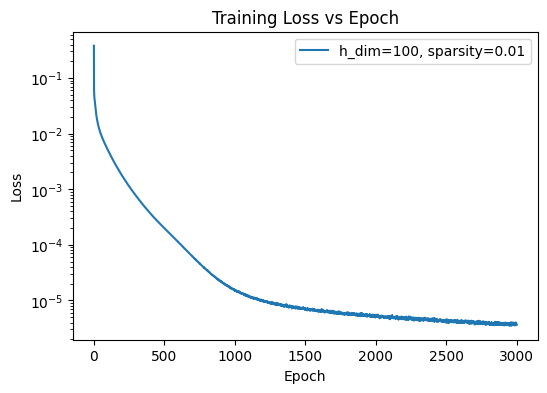

 Done: h_dim=100, sparsity_target=0.01, Final Loss=0.000003680


>>> Training SAE | h_dim=100, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.243133671
Epoch 500/3000 - Loss: 0.000044407
Epoch 1000/3000 - Loss: 0.000011389
Epoch 1500/3000 - Loss: 0.000007990
Epoch 2000/3000 - Loss: 0.000006479
Epoch 2500/3000 - Loss: 0.000005506
 Done: h_dim=100, sparsity_target=0.04, Final Loss=0.000005346



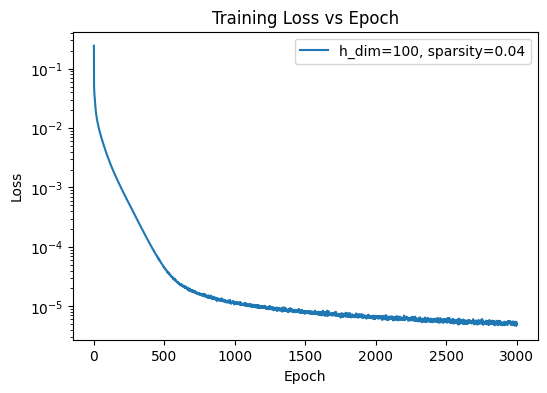

 Done: h_dim=100, sparsity_target=0.04, Final Loss=0.000005346


>>> Training SAE | h_dim=100, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.133796202
Epoch 500/3000 - Loss: 0.000035008
Epoch 1000/3000 - Loss: 0.000015175
Epoch 1500/3000 - Loss: 0.000012417
Epoch 2000/3000 - Loss: 0.000009601
Epoch 2500/3000 - Loss: 0.000008369
 Done: h_dim=100, sparsity_target=0.08, Final Loss=0.000007730



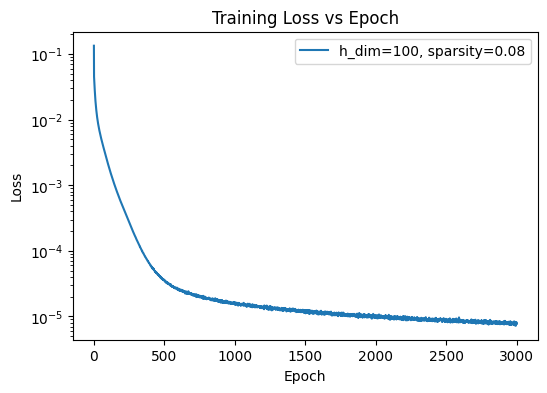

 Done: h_dim=100, sparsity_target=0.08, Final Loss=0.000007730


>>> Training SAE | h_dim=100, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.181365840
Epoch 500/3000 - Loss: 0.000037483
Epoch 1000/3000 - Loss: 0.000019404
Epoch 1500/3000 - Loss: 0.000015558
Epoch 2000/3000 - Loss: 0.000013030
Epoch 2500/3000 - Loss: 0.000011792
 Done: h_dim=100, sparsity_target=0.12, Final Loss=0.000011530



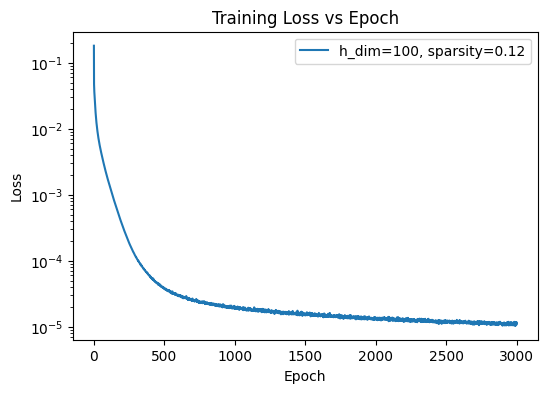

 Done: h_dim=100, sparsity_target=0.12, Final Loss=0.000011530


>>> Training SAE | h_dim=120, sparsity_target=0.01
Epoch 0/3000 - Loss: 0.179880184
Epoch 500/3000 - Loss: 0.000145069
Epoch 1000/3000 - Loss: 0.000011814
Epoch 1500/3000 - Loss: 0.000006271
Epoch 2000/3000 - Loss: 0.000004729
Epoch 2500/3000 - Loss: 0.000003677
 Done: h_dim=120, sparsity_target=0.01, Final Loss=0.000003409



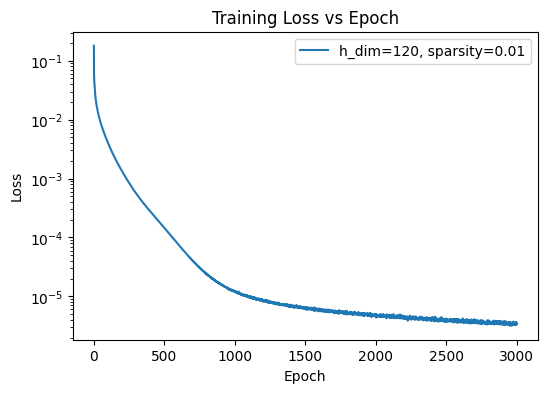

 Done: h_dim=120, sparsity_target=0.01, Final Loss=0.000003409


>>> Training SAE | h_dim=120, sparsity_target=0.04
Epoch 0/3000 - Loss: 0.131586852
Epoch 500/3000 - Loss: 0.000033647
Epoch 1000/3000 - Loss: 0.000011828
Epoch 1500/3000 - Loss: 0.000008502
Epoch 2000/3000 - Loss: 0.000006778
Epoch 2500/3000 - Loss: 0.000006008
 Done: h_dim=120, sparsity_target=0.04, Final Loss=0.000005265



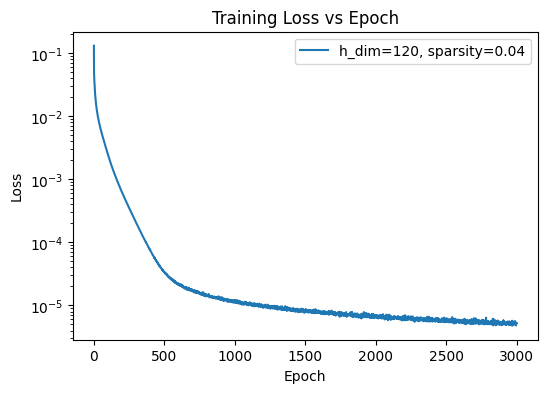

 Done: h_dim=120, sparsity_target=0.04, Final Loss=0.000005265


>>> Training SAE | h_dim=120, sparsity_target=0.08
Epoch 0/3000 - Loss: 0.228161479
Epoch 500/3000 - Loss: 0.000039180
Epoch 1000/3000 - Loss: 0.000015780
Epoch 1500/3000 - Loss: 0.000011991
Epoch 2000/3000 - Loss: 0.000010044
Epoch 2500/3000 - Loss: 0.000008596
 Done: h_dim=120, sparsity_target=0.08, Final Loss=0.000007749



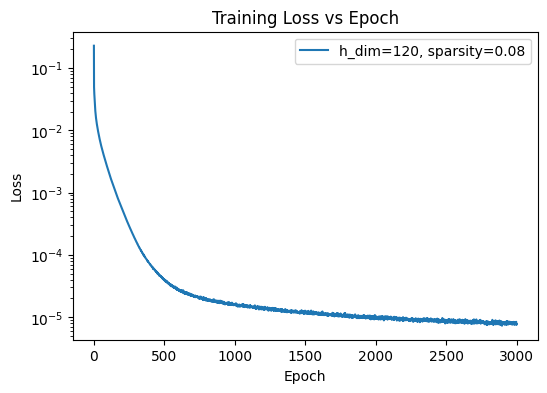

 Done: h_dim=120, sparsity_target=0.08, Final Loss=0.000007749


>>> Training SAE | h_dim=120, sparsity_target=0.12
Epoch 0/3000 - Loss: 0.250167992
Epoch 500/3000 - Loss: 0.000039002
Epoch 1000/3000 - Loss: 0.000019299
Epoch 1500/3000 - Loss: 0.000015004
Epoch 2000/3000 - Loss: 0.000013312
Epoch 2500/3000 - Loss: 0.000012276
 Done: h_dim=120, sparsity_target=0.12, Final Loss=0.000010739



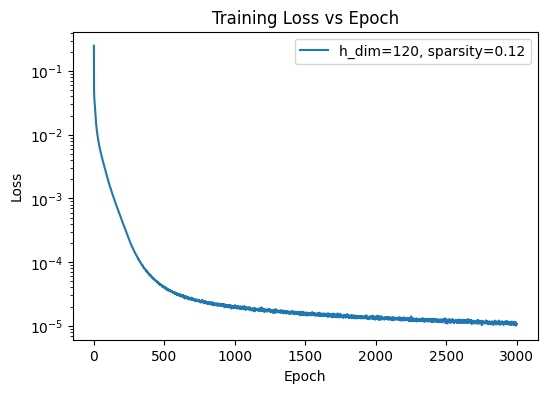

 Done: h_dim=120, sparsity_target=0.12, Final Loss=0.000010739


 Best SAE configuration: h_dim=120, sparsity_target=0.01, loss=0.000003409


In [ ]:
# Train SAE for different latent dimensions
def train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
              sparsity_lambda, lr, n_epochs, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = hidden_tensor.shape[1]
    sae = SparseAutoencoder(in_dim, h_dim, sparsity_lambda, sparsity_target).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
    epoch_losses = []

    print(f"\n>>> Training SAE | h_dim={h_dim}, sparsity_target={sparsity_target}")
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            encoded, decoded = sae(batch_x)
            loss = sae.loss_function(decoded, batch_x, encoded)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)

        if epoch % 500 == 0:
            print(f"Epoch {epoch}/{n_epochs} - Loss: {avg_loss:.9f}")

    final_loss = epoch_losses[-1]
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")

    plt.figure(figsize=(6,4))
    plt.plot(range(n_epochs), epoch_losses, label=f"h_dim={h_dim}, sparsity={sparsity_target}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.title("Training Loss vs Epoch")
    plt.legend()
    plt.show()

    final_loss = total_loss / len(dataloader)
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")
    return final_loss, sae


# Experiment configurations


h_dims_list = [60,80,100,120]      # hidden layer sizes
sparsity_targets = [0.01,0.04,0.08,0.12]   # sparsity targets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = {}
best_loss = float('inf')
best_config = None
best_model = None

# Train models & track best configuration
for h_dim in h_dims_list:
    losses = []
    for sparsity_target in sparsity_targets:
        final_loss, sae_model = train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
                                          sparsity_lambda=2e-4, lr=1e-3, n_epochs=3000, device=device)
        losses.append(final_loss)

        # Track the best model
        if final_loss < best_loss:
            best_loss = final_loss
            best_config = (h_dim, sparsity_target)
            best_model = sae_model

    results[h_dim] = losses

print(f"\n Best SAE configuration: h_dim={best_config[0]}, sparsity_target={best_config[1]}, loss={best_loss:.9f}")

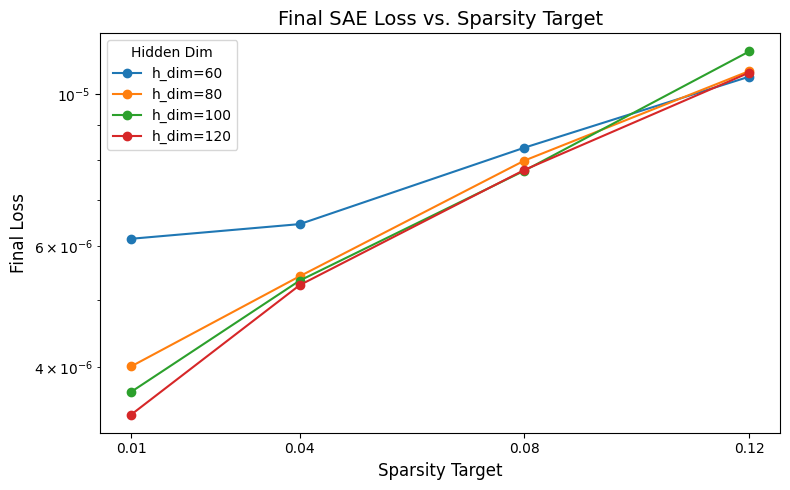

Saved mini-batch encoded activations: (139, 120)
Saved SAE encoded features shape: (3475, 120)


In [ ]:

plt.figure(figsize=(8, 5))
for h_dim, losses in results.items():
    plt.plot(sparsity_targets, losses, marker='o', label=f'h_dim={h_dim}')
plt.xlabel('Sparsity Target', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final SAE Loss vs. Sparsity Target', fontsize=14)
plt.legend(title='Hidden Dim')
plt.xticks(sparsity_targets)
plt.yscale('log')
plt.tight_layout()
plt.show()


# Save Encoded Outputs for Best Model
sae = best_model

# Save activation for any mini-batch
any_batch, _ = next(iter(dataloader))
with torch.no_grad():
    last_batch_encoded, _ = sae(any_batch.to(device))

any_batch_encoded = last_batch_encoded.cpu().numpy()
np.save("any_batch_encoded.npy", any_batch_encoded)
print("Saved mini-batch encoded activations:", any_batch_encoded.shape)

# Save full dataset encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_full_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)

In [1]:
# Convert hidden activations to a DataFrame
activations = np.array(any_batch_encoded)  # (batch_size, num_neurons)
df = pd.DataFrame(activations, columns=[f"Neuron {i+1}" for i in range(activations.shape[1])])
# Show first 10 samples (rows) and first 10 neurons (columns) for readability
df_subset = df.iloc[:10, :10]

df_subset


NameError: name 'np' is not defined

We have printed the activation values of neurons for each sample in the mini-batch.
    
Each row corresponds to the activation of neuron for a single sample from the mini-batch.

 As we can see, the tabular representation of activations lists raw numeric values for each neuron (columns) across samples in the mini-batch (rows).
 However, these values alone are not visually intuitive it is difficult to quickly identify which neurons/feature are more active, or how activation intensity varies across samples.




In [ ]:
#  Load encoded activations
encoded_full = np.load("train_full_hidden_encoded.npy")
any_batch_encoded = np.load("any_batch_encoded.npy")

num_samples, num_neurons = encoded_full.shape
print(f"Full encoded shape: {encoded_full.shape}")

# Compute per-neuron threshold from mini batch
K = 10
thresholds = np.zeros(num_neurons)
for n in range(num_neurons):
    topk_values = np.sort(any_batch_encoded[:, n])[-K:]
    thresholds[n] = np.mean(topk_values)
print("Computed thresholds for all neurons.")

#  Check activation per neuron for each sample
active_matrix = encoded_full > thresholds

# Count how many samples activate each neuron
neuron_activity_counts = np.sum(active_matrix, axis=0)
# axis zero means For each neuron, count how many samples in which it is activated

#  Display top 10 most frequently active neurons
top_indices = np.argsort(-neuron_activity_counts)[:10]
print("\nTop 10 most active neurons:")
for idx in top_indices:
    print(f"Neuron {idx}: active in {neuron_activity_counts[idx]} / {num_samples} samples")


Full encoded shape: (3475, 120)
Computed thresholds for all neurons.

Top 10 most active neurons:
Neuron 65: active in 215 / 3475 samples
Neuron 81: active in 206 / 3475 samples
Neuron 41: active in 204 / 3475 samples
Neuron 46: active in 194 / 3475 samples
Neuron 80: active in 193 / 3475 samples
Neuron 100: active in 191 / 3475 samples
Neuron 13: active in 189 / 3475 samples
Neuron 83: active in 188 / 3475 samples
Neuron 119: active in 179 / 3475 samples
Neuron 102: active in 177 / 3475 samples


Now we want to check which sample input activates most of feature/neurosn in the best trained SAE

In [ ]:
sample_activity_counts = np.sum(active_matrix, axis=1)
# axix 1 means count how many neurons are active for a sample

# Find the sample(s) that activated the most neurons
most_active_sample_idx = np.argmax(sample_activity_counts)
most_active_count = sample_activity_counts[most_active_sample_idx]

print(f"\nSample {most_active_sample_idx} activated {most_active_count} / {num_neurons} neurons (most active).")

# Display top most activating samples
top_samples = np.argsort(-sample_activity_counts)[:20]
print("\nTop 10 most neuron-activating samples:")
for idx in top_samples:
    print(f"Sample {idx}: activated {sample_activity_counts[idx]} features/neurons")


Sample 2700 activated 22 / 120 neurons (most active).

Top 10 most neuron-activating samples:
Sample 2925: activated 22 features/neurons
Sample 2940: activated 22 features/neurons
Sample 3440: activated 22 features/neurons
Sample 2700: activated 22 features/neurons
Sample 3445: activated 21 features/neurons
Sample 2701: activated 21 features/neurons
Sample 2250: activated 21 features/neurons
Sample 2926: activated 21 features/neurons
Sample 3400: activated 21 features/neurons
Sample 2715: activated 21 features/neurons
Sample 2475: activated 21 features/neurons
Sample 2025: activated 20 features/neurons
Sample 1800: activated 20 features/neurons
Sample 2026: activated 20 features/neurons
Sample 3435: activated 20 features/neurons
Sample 3429: activated 20 features/neurons
Sample 3425: activated 20 features/neurons
Sample 3379: activated 20 features/neurons
Sample 3151: activated 20 features/neurons
Sample 2251: activated 20 features/neurons
